# Time-lapse tracer experiment in sand column
In this experiment, time-lapse ERT is used to monitor the infiltration of a tracer in a sand column.

- injection at 40 mm/h
- 2000 uS/cm for 120 min
- seq2 with 250 ms on-time

Plan of the experimental setup:

<img src="img/column-schema.jpg" width="400" height="1000">

In [18]:
 # trick to import a resipy from a local copy (you won't need that if you `pip install resipy`)
import sys 
sys.path.append('../src')

from resipy import R2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pyvista as pv
import os
import shutil

wd = '../src/examples/dc-3d-timelapse-column/'

In [22]:
# each sequence is actually composed of 24 repeated injection
# the function below separate each set of injection into different
# dataframe
def writedf(fnames, wd):
    if os.path.exists(wd + 'data/'):
        shutil.rmtree(wd + 'data/')
    os.mkdir(wd + 'data/')
    dfs = []
    c = 0
    for i, fname in enumerate(fnames):
        df = pd.read_csv(datadir + 'ert/' + fname + '.csv')
        for j in range(df.shape[0]//100):
            sdf = df[j*100:(j+1)*100]
            dfs.append(sdf)
            c += 1
            sdf.to_csv(wd + 'data/dataset{:03.0f}.csv'.format(c), index=False)
    return dfs

def showOutflow(fname, ax=None, label=''):
    df = pd.read_csv(fname, header=2, sep=' ')
    df['hh:mm:ss'] = pd.to_datetime(df['hh:mm:ss'])
    df['t'] = [(a - df['hh:mm:ss'].values[0]).seconds for a in df['hh:mm:ss']]
    if ax is None:
        fig, ax = plt.subplots()
    ax.plot(df['t'], df['mS'], '.-', label=label)
    ax.set_xlabel('Time [s]')
    ax.set_ylabel('mS')

def showEvol(k, dt=2, ax=None): # dt is time interval in seconds
    vals = np.vstack([s.df['resist'].values[0::20] for s in k.surveys])
    xx = np.arange(0, len(k.surveys))*dt
    if ax == None:
        fig, ax = plt.subplots()
    for i in range(vals.shape[1]):
        ax.semilogy(xx, vals[:,i], '.-', label='ring {:d}'.format(i+1))
    ax.set_xlabel('Time [s]')
    ax.legend()
    ax.set_ylabel(r'Transfer Resistance [$\Omega$]')

In [25]:
fnames = ['202030201',
          '202030202']
k = R2(wd, typ='R3t')
# k = R2(typ='R3t')
# k.dirname = wd
dfs = writedf(fnames, wd)
k.createTimeLapseSurvey(wd + 'data/')

In [36]:
radius = 6.5/2 # cm
angles = np.linspace(0, 2*np.pi, 13)[:-1] # radian
celec = np.c_[radius*np.cos(angles), radius*np.sin(angles)]
elec = np.c_[np.tile(celec.T, 8).T, np.repeat(6.5+np.arange(0, 8*5.55, 5.55)[::-1], 12)]
print(k.elec.shape)

print(k.elec)

s2 = np.unique(k.surveys[0].df[['a','b','m','n']].values.flatten())
print(s2)
print(len(s2))

ielec = k.elec['x'].astype(int).values # electrode indices used in the sequence
print(ielec)

x = elec[ielec,:]
print(x.shape)

y = k._num2elec(x)
print(y)
k.setElec(x)

(23, 6)
       x    y    z  remote  buried label
0    0.0  0.0  0.0   False   False     1
1    3.0  0.0  0.0   False   False     2
2    6.0  0.0  0.0   False   False     3
3    9.0  0.0  0.0   False   False     4
4   12.0  0.0  0.0   False   False     5
5   15.0  0.0  0.0   False   False     6
6   18.0  0.0  0.0   False   False     7
7   21.0  0.0  0.0   False   False     8
8   24.0  0.0  0.0   False   False     9
9   27.0  0.0  0.0   False   False    10
10  30.0  0.0  0.0   False   False    11
11  33.0  0.0  0.0   False   False    12
12  36.0  0.0  0.0   False   False    13
13  39.0  0.0  0.0   False   False    14
14  42.0  0.0  0.0   False   False    15
15  45.0  0.0  0.0   False   False    16
16  48.0  0.0  0.0   False   False    17
17  51.0  0.0  0.0   False   False    18
18  54.0  0.0  0.0   False   False    19
19  57.0  0.0  0.0   False   False    20
20  60.0  0.0  0.0   False   False    21
21  63.0  0.0  0.0   False   False    22
22  66.0  0.0  0.0   False   False    23
['0' '1'

ValueError: The following electrode labels are missing from the electrode declaration: 0

In [27]:
print(k.elec)
k.importElec(wd + 'elec.csv')
k.surveys = k.surveys[::2][:100] # 41.25 s per survey (each survey is 100 quadrupoles) so every 2.75 min
#k.param['reg_mode'] = 1 # background constrain
k.importMesh(datadir + 'mesh3d.dat', flag_3D=True)
k.param['node_elec'] = np.c_[np.arange(len(ielec))+1, ielec+1]
k.param['num_xy_poly'] = 0
k.param['xy_poly_table'] = []
k.param['zmin'] = -10
k.param['zmax'] = 50
k.param['a_wgt'] = 0.02
k.invert(parallel=True)
#k.getResults()

       x    y    z  remote  buried label
0    0.0  0.0  0.0   False   False     1
1    3.0  0.0  0.0   False   False     2
2    6.0  0.0  0.0   False   False     3
3    9.0  0.0  0.0   False   False     4
4   12.0  0.0  0.0   False   False     5
5   15.0  0.0  0.0   False   False     6
6   18.0  0.0  0.0   False   False     7
7   21.0  0.0  0.0   False   False     8
8   24.0  0.0  0.0   False   False     9
9   27.0  0.0  0.0   False   False    10
10  30.0  0.0  0.0   False   False    11
11  33.0  0.0  0.0   False   False    12
12  36.0  0.0  0.0   False   False    13
13  39.0  0.0  0.0   False   False    14
14  42.0  0.0  0.0   False   False    15
15  45.0  0.0  0.0   False   False    16
16  48.0  0.0  0.0   False   False    17
17  51.0  0.0  0.0   False   False    18
18  54.0  0.0  0.0   False   False    19
19  57.0  0.0  0.0   False   False    20
20  60.0  0.0  0.0   False   False    21
21  63.0  0.0  0.0   False   False    22
22  66.0  0.0  0.0   False   False    23


ValueError: The following electrode labels are missing from the electrode declaration: 0

In [31]:
k.meshResults[0].attr_cache.keys()

dict_keys(['Resistivity', 'Resistivity(log10)', 'Sensitivity_map(log10)', 'Parameter_zones'])

In [42]:
#k.computeDiff() # run once
res0 = np.array(k.meshResults[0].attr_cache['Resistivity'])
for i, m in enumerate(k.meshResults):
    res = np.array(m.attr_cache['Resistivity'])
    m.attr_cache['difference(percent)'] = list((res-res0)/res0*100)
    m.write_vtk(wd + 'out{:03d}.vtk'.format(i))

(0, 16186.8)

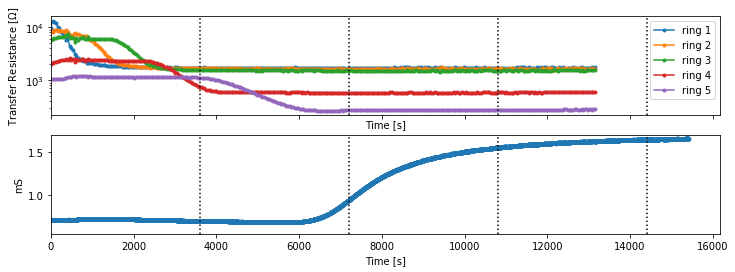

In [20]:
k.showRMS()
steps = np.array([60, 120, 180, 240])*60
fig, axs = plt.subplots(2, 1, sharex=True, figsize=(12,4))
showEvol(k, dt=41.25, ax=axs[0])
[axs[0].axvline(a, color='k', linestyle=':') for a in steps]
showOutflow(datadir + 'outflow/20030201.txt', ax=axs[1])
[axs[1].axvline(a, color='k', linestyle=':') for a in steps]
axs[1].set_ylim([0.55, 1.7])
axs[1].set_xlim([0, None])
#fig.savefig(outputdir + 'evolution.png')

In [ ]:
wd = invdir + '200311/'
p = pv.Plotter(notebook=True)
for i in np.arange(1, len(k.surveys), 10):
    offset = i
    mesh = pv.read(wd + 'out{:03d}.vtk'.format(i+1))
    mesh.translate([offset, 0, 0])
    p.add_mesh(mesh, scalars='difference(percent)', cmap='blues_r', clim=(-50, 0))
    melec = pv.PolyData(elec)
    melec.translate([offset, 0, 0])
    p.add_mesh(melec)
    p.add_text('{:.2f} min'.format(i*41.25/60), position=(160 + offset*7, 550), font_size=6)
p.view_xz()
p.show()

NOTE: opening all the vtk in paraview, enables to create an animated gif that shows the tracer progression in the column.

<img src="./img/column.gif" width="500">